# Filter Delta2 Data Pseudomonas aeruginosa
 
In this notebook we filter the time-lapse data of Pseudomonas aeruginosa mutant strains with cdg sensor growing on agar-pads

---

## Import packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns

import pathlib

---

## Setup Folders

In [2]:
proj_dir = pathlib.Path(pathlib.Path.home(), 'switchdrive', 'Biozentrum', 'Andreas')
processed_dir = proj_dir / 'processed'
data_dir = proj_dir / 'outputPA'

---

## Load Data

We also add a unique ID for each cell pair (two cells with shared parent) by combining strain id, replicate id, and par id

In [3]:
#load data frame
df_name = data_dir / 'pa_combined_data.csv'
df = pd.read_csv(df_name, index_col=0)

#add unique id of cell by combining strain and replicate
df['uni_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_cell'].map(str)
df['uni_par_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_par'].map(str)
df.head()


,id_seg,id_cell,id_par,id_colony,id_d1,id_d2,id_sib,frames,new_pole,old_pole,...,fluo3,x_pos,y_pos,generation,age,strain,movie_name,replicate,uni_id,uni_par_id
0,0,0,-1,0,1,86,-1,0,[ 352 1020],[ 351 1012],...,2763.903226,1015.919355,351.548387,0.0,0,UJP1964,UJP1964_TL_PseudoMutants_D11optScar_01_06,0,UJP1964-0-0,UJP1964-0--1
1,0,0,-1,0,1,86,-1,1,[ 357 1020],[ 355 1009],...,2894.195122,1014.560976,355.676829,0.0,1,UJP1964,UJP1964_TL_PseudoMutants_D11optScar_01_06,0,UJP1964-0-0,UJP1964-0--1
2,0,0,-1,0,1,86,-1,2,[ 357 1020],[ 355 1007],...,2992.681081,1013.940541,356.086486,0.0,2,UJP1964,UJP1964_TL_PseudoMutants_D11optScar_01_06,0,UJP1964-0-0,UJP1964-0--1
3,0,0,-1,0,1,86,-1,3,[ 361 1020],[ 359 1007],...,3151.106280,1012.946860,359.449275,0.0,3,UJP1964,UJP1964_TL_PseudoMutants_D11optScar_01_06,0,UJP1964-0-0,UJP1964-0--1
4,0,0,-1,0,1,86,-1,4,[ 358 1020],[ 356 1010],...,3208.921466,1013.832461,357.115183,0.0,4,UJP1964,UJP1964_TL_PseudoMutants_D11optScar_01_06,0,UJP1964-0-0,UJP1964-0--1


---

## Check data

We first plot the life time distribution full lineages (those with parent and two offspring)


Text(0.5, 0, 'life time of cell [frames]')

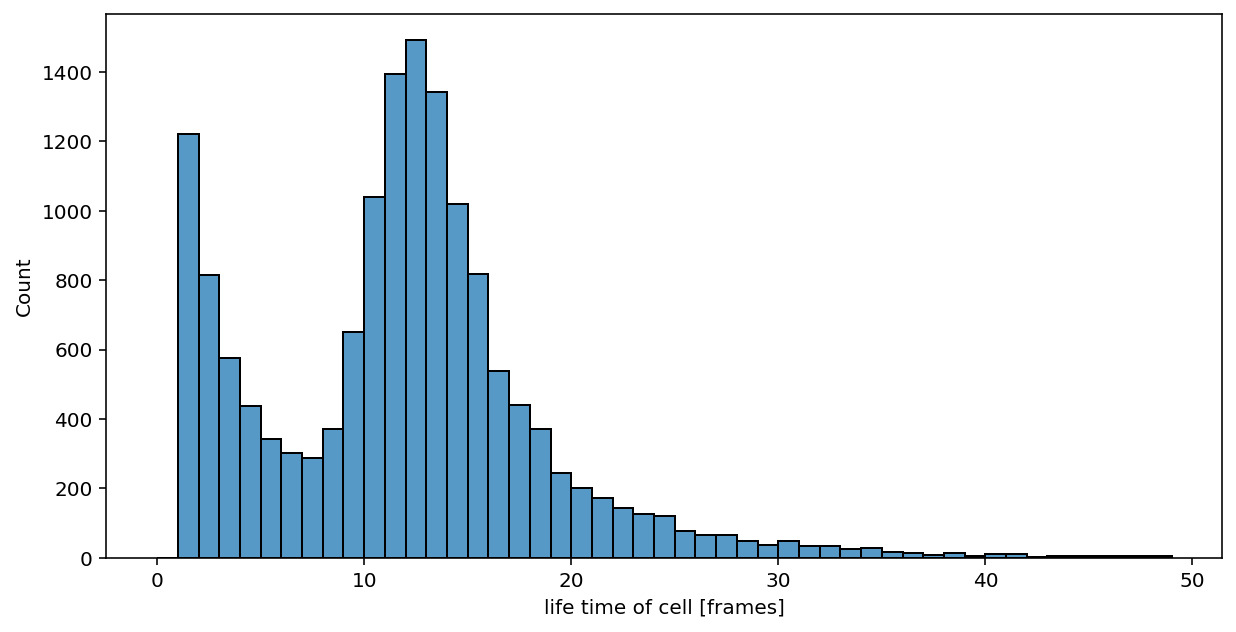

In [4]:
#plot cell life_time for full lineages
has_mom = df["id_par"] > -1
has_d1 = df["id_d1"] > -1
has_d2 = df["id_d2"] > -1
full_lin = has_mom & has_d1 & has_d2

df_compl = df[full_lin].copy()
ax = sns.histplot(data=df_compl.groupby('uni_id').size(), bins=np.arange(50))
ax.set_xlabel('life time of cell [frames]')


Next we analyze the change in length between two frames

[Text(0.5, 1.0, 'min change in length between frames')]

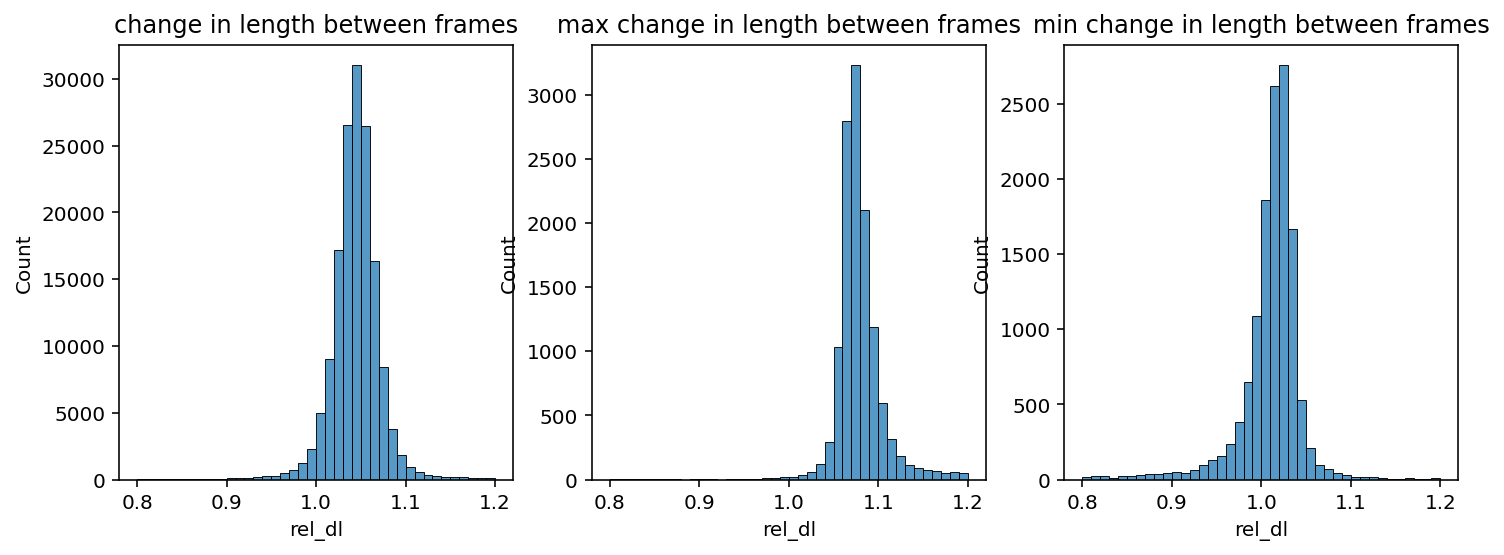

In [5]:
#calc length change
dl = df_compl.groupby('uni_id')['length'].diff()
df_compl['rel_dl'] = (df_compl['length'] + dl)/df_compl['length']
max_dl = df_compl.groupby('uni_id')['rel_dl'].max()
min_dl = df_compl.groupby('uni_id')['rel_dl'].min()

fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.histplot(ax=axs[0], data=df_compl, x='rel_dl', bins=np.linspace(0.8,1.2,41)).set(title='change in length between frames')
sns.histplot(ax=axs[1], data=max_dl, bins=np.linspace(0.8,1.2,41)).set(title='max change in length between frames')
sns.histplot(ax=axs[2], data=min_dl, bins=np.linspace(0.8,1.2,41)).set(title='min change in length between frames')


Next we analyze the change in length across cell divisions 

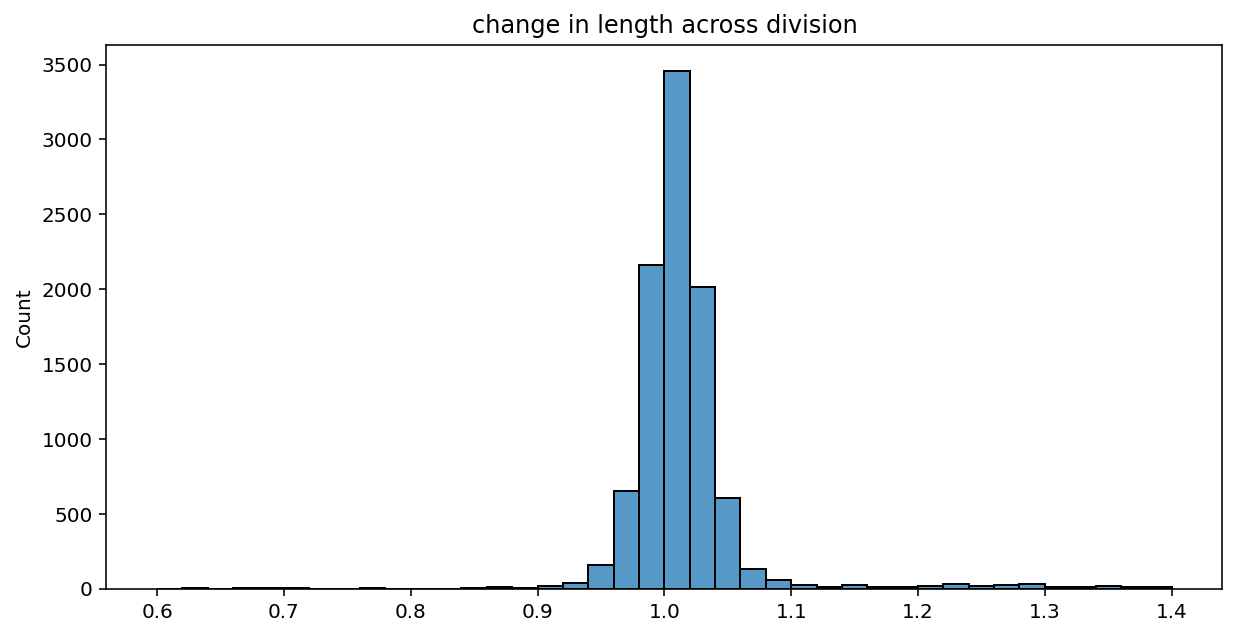

In [6]:
#analyze change in length
dl_list = []
movies_grouped = df_compl.groupby('movie_name')

for name, movie in movies_grouped:
    cells_grouped = movie.groupby('uni_id')
    for name, cell in cells_grouped:
        
        try:
            sis_idx = movie['id_cell'] == cell['id_sib'].iloc[0]
            par_idx = movie['id_cell'] == cell['id_par'].iloc[0]
            
            #get length
            len_cel = cell['length'].iloc[0]
            len_sib = movie.loc[sis_idx, 'length'].iloc[0]
            len_par = movie.loc[par_idx, 'length'].iloc[-1]
        
            dl_list.append((len_cel + len_sib) / len_par)
        except:
            continue
        
sns.histplot(data=dl_list, bins=np.linspace(0.6,1.4,41)).set(title='change in length across division');

---

## Filter data

We use following checks:

 - We only consider cells whose division is properly tracked (both daughters are identified) and where both offspring cells are tracked for at least `min_num_frm` frames
 - We filter out lineages where length changes too much between division
   - We calculate length change as $\frac{l_{d1}+l_{d2}}{l_p}$
 - We filter out lineages where the length changes too much during life time
    - We calculate length change as $\frac{l(t+\Delta t)}{l(t)} = 2^{\Delta t / t_d}$

In [15]:
def check_growth(len, min_dl, max_dl):
    """Check if change in length between frames stays within bounds

    Parameters
    ----------
    len : np.array
        length of cell over time
    min_dl : float
        lowest value of l(t+1)/l(t) that is allowed
    max_dl : float
        highest value of l(t+1)/l(t) that is allowed

    Returns
    -------
    Boolean
        True if  min_dl < l(t+1)/l(t) < max_dl for all t; false otherwise
    """
    dl = len[1:] / len[0:-1]
    return np.all(dl>min_dl) & np.all(dl<max_dl)


def filter_tracks(movie, par_cell, filter_par, reason_skipped):
    """Filter cell tracks based on criteria

    Parameters
    ----------
    movie : pd.DataFrame 
        grouped by DataFrame containing data of single position
    par_cell : pd.DataFrame 
        grouped by DataFrame containing data of single cell, whose offspring will be analyzed
    filter_par : dictionary
        dictionary with filter parameter
    reason_skipped : dictionary
        dictionary that tracks reason why cell was skipped 

    Returns
    -------
    pd.DataFrame or None
        If tracking passes all criteria output is a DataFrame containing paired data of both offspring cells of par_cell, else a None is returned 
    """
    
    #init output
    new_df = None
    
    #check if division was tracked
    has_d1 = par_cell["id_d1"].iloc[0] > -1
    has_d2 = par_cell["id_d2"].iloc[0] > -1
    paired_lin = has_d1 & has_d2
    if not paired_lin: reason_skipped['division not tracked'] += 1

    if paired_lin:
        #get offspring cells
        d1_idx = movie['id_cell'] == par_cell["id_d1"].iloc[0]
        d2_idx = movie['id_cell'] == par_cell["id_d2"].iloc[0]
    
        #check if both offspring cells have been tracked for full lineage
        has_d11 = movie.loc[d1_idx, 'id_d1'].iloc[0] > -1
        has_d12 = movie.loc[d1_idx, 'id_d2'].iloc[0] > -1
        has_d21 = movie.loc[d2_idx, 'id_d1'].iloc[0] > -1
        has_d22 = movie.loc[d2_idx, 'id_d2'].iloc[0] > -1
        full_lin = has_d11 & has_d12 & has_d21 & has_d22
       
        if not full_lin: reason_skipped['offspring not fully tracked'] +=1

        if full_lin:
            len_d1 = movie.loc[d1_idx, 'length']
            len_d2 = movie.loc[d2_idx, 'length']
                
            #check length change across division    
            # [l(offspring 1, t=0) +  l(offspring 2, t=0)] / l(mother, t=last)                   
            dl = (len_d1.iloc[0] + len_d2.iloc[0]) / par_cell['length'].iloc[-1]
            div_ok = (dl > filter_par['min_dl_div']) &  (dl < filter_par['max_dl_div'])
            if not div_ok: reason_skipped['dL error at div.'] +=1
            
            if div_ok:        
                #crop movies to shortest length
                lt1 = len_d1.size
                lt2 = len_d2.size
                
                frms = np.arange(min(len_d1.size, len_d2.size))
                len_d1 = len_d1.iloc[frms].values 
                len_d2 = len_d2.iloc[frms].values
                
                #check length change over time  
                len_ok = check_growth(len_d1, filter_par['min_dl'], filter_par['max_dl']) & \
                        check_growth(len_d2, filter_par['min_dl'], filter_par['max_dl'])
                if not len_ok: reason_skipped['dL error'] +=1

                if len_ok:
                    #cell pair ok, process
                    reason_skipped['properly tracked'] +=1
                    
                    id_d1 = par_cell["id_d1"].iloc[0]
                    id_d2 = par_cell["id_d2"].iloc[0]
                    
                    #copy data frame   
                    cell_d1 = movie.loc[d1_idx, :]
                    new_df = cell_d1.iloc[frms, df.columns.get_indexer(cols)].reset_index(drop=True)
                    
                    #get fluorescent values of cdg
                    fluo_d1 = cell_d1[filter_par['cdg_ch']].iloc[frms].values 
                    fluo_d2 = movie.loc[d2_idx, filter_par['cdg_ch']].iloc[frms].values 
                    
                    ref_d1 = cell_d1[filter_par['ref_ch']].iloc[frms].values 
                    ref_d2 = movie.loc[d2_idx, filter_par['ref_ch']].iloc[frms].values 

                    #calc fluorescence ratio
                    rel_fluor = fluo_d1 / fluo_d2
                    fluo_ratio = rel_fluor.mean()
                    
                    #order d1 and d2 based on cdg levels
                    d1_is_high = True if fluo_ratio>1 else False
                    
                    #normalize fluor
                    max_fluor = fluo_d1[0] if fluo_ratio>1 else fluo_d2[0]
                    fluo_d1_norm = fluo_d1 / max_fluor
                    fluo_d2_norm = fluo_d2 / max_fluor
                    
                    relt1 = movie.loc[d1_idx, 'age'].iloc[frms].values  / lt1
                    relt2 = movie.loc[d2_idx, 'age'].iloc[frms].values  / lt1
                                                            
                    #add new fields to df
                    new_df['relt_dh'] =  relt1 if d1_is_high  else relt2
                    new_df['relt_dl'] =  relt2 if d1_is_high  else relt1
                    
                    new_df['cdg_ref_dh'] =  fluo_d1/ref_d1 if d1_is_high  else fluo_d2/ref_d2
                    new_df['cdg_ref_dl'] =  fluo_d2/ref_d2 if d1_is_high  else fluo_d1/ref_d1
                    
                    new_df['cdg_dh'] =  fluo_d1 if d1_is_high  else fluo_d2
                    new_df['cdg_dl'] =  fluo_d2 if d1_is_high  else fluo_d1
                    new_df['cdg_norm_dh'] =  fluo_d1_norm if d1_is_high  else fluo_d2_norm
                    new_df['cdg_norm_dl'] =  fluo_d2_norm if d1_is_high  else fluo_d1_norm
                    new_df['len_dh'] =  len_d1 if d1_is_high  else len_d2
                    new_df['len_dl'] =  len_d2 if d1_is_high  else len_d1
                    new_df['idc_dh'] =  id_d1 if d1_is_high  else id_d2
                    new_df['idc_dl'] =  id_d2 if d1_is_high  else id_d1
                    new_df['rel_cdg_hl'] = 1/rel_fluor if d1_is_high else rel_fluor

    return new_df

These are the filter settings we use:

- `max_dl`: 1.12 ->  max value $l(t+1)/l(t)$ (eq. to td=30min) 
- `min_dl`: 0.92 -> min value $l(t+1)/l(t)$ 
- `max_dl_div`: 1.2 -> max value $l(t+1)/l(t)$ across division  
- `min_dl_div`: 0.94 -> min value $l(t+1)/l(t)$ across division  
- `min_num_frm`: 8 -> min number of frames to track (eq to 40min)
- `cdg_ch`: 'fluo1'  -> cdg channel name

In [16]:
#filter settings
filter_par = {
        'max_dl': 1.12,  
        'min_dl': 0.92,  
        'max_dl_div': 1.2,
        'min_dl_div': 0.94, 
        'min_num_frm': 8,
        'cdg_ch': 'fluo1',
        'ref_ch': 'fluo3'}

#columns to copy
cols = ['uni_par_id', 'strain', 'movie_name', 'replicate', 'id_colony', 
        'id_par', 'frames', 'generation', 'age']

#keep track of why lineages are skipped
reason_skipped = { \
        'division not tracked':0,
        'offspring not fully tracked':0,
        'too few frames':0,
        'dL error at div.':0,
        'dL error':0,
        'properly tracked':0}

#init output
df_list = []
#loop movies
movies_grouped = df.groupby('movie_name')
for _, movie in movies_grouped: 
#loop by parent cells
    cells_grouped = movie.groupby('uni_par_id') 
    for _, par_cell in cells_grouped:
        # filter cells    
        new_df = filter_tracks(movie, par_cell, filter_par, reason_skipped)
        if new_df is not None:
                df_list.append(new_df)
                
df_paired_1h = pd.concat(df_list)              

Show reason why lineages were skipped

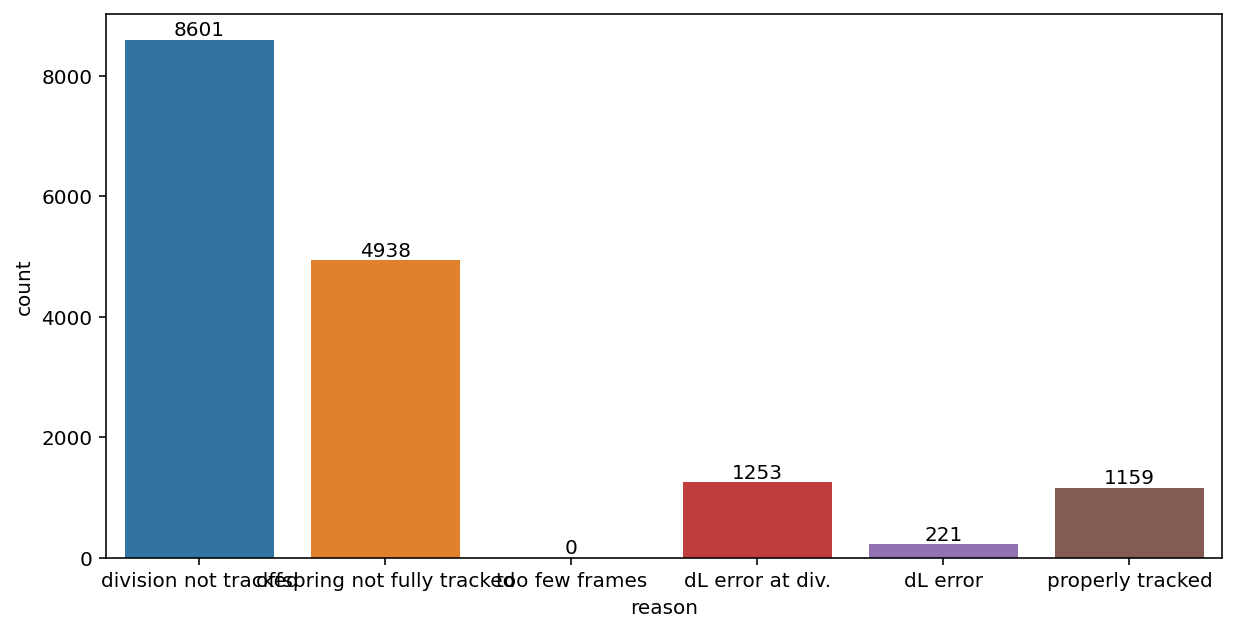

In [17]:
df_stats = pd.DataFrame( [ [k,v] for k,v in reason_skipped.items()],columns=['reason','count'])
ax = sns.barplot(data=df_stats, x='reason', y='count')
ax.bar_label(ax.containers[0]);

---

## Store Data

In [18]:
out_name = processed_dir / 'pseudomonas_combined_filtered_paired_data_full_lin.csv'
df_paired_1h.to_csv(out_name)

---

## Show number of data points per strain

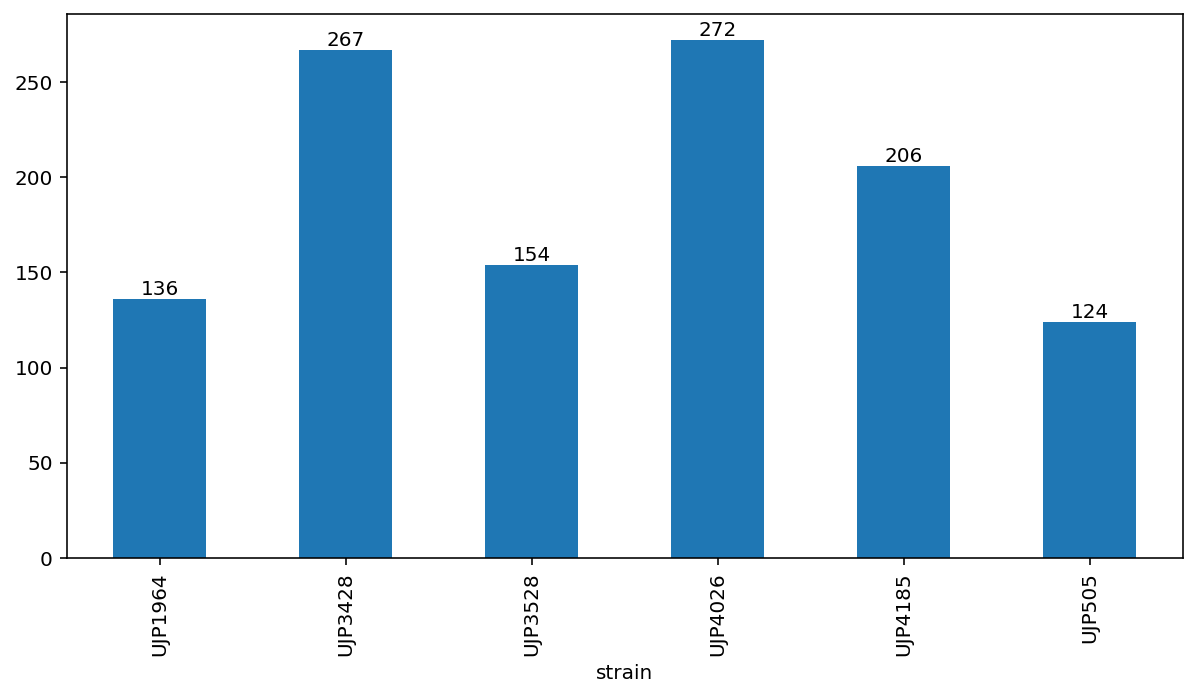

In [19]:
first_frame = df_paired_1h.groupby('uni_par_id').first()
num_lin_per_strain = first_frame.groupby('strain').size() 
num_lin_per_strain.head(n=18)
ax = num_lin_per_strain.plot(kind='bar')
ax.bar_label(ax.containers[0]);